In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

cwd = os.getcwd() #grabs current working directory
skipcols = ['Source']

This journal documents the maths undertaken to estimate the amount of aluminium per meter squared of module as contributed by the frame (i.e. not the aluminium found within the module).

In [2]:
al_frame_raw = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/marketshare_moduleSize_al_frames.csv", 
                           index_col='Year', usecols=lambda x: x not in skipcols)
module_size_raw = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/MarketShare_moduleSize_Peeters2017.csv", 
                           index_col='Year')

First, we're going to create a lovely baseline from the module size data as derived from Peeters et al. 2017. These data were drawn from PV datasheets, and given a marketshare value from 1992 through 2015. This data may be more specific to Flanders, but it appears to be consistent with ITRPV 2019 and 2020 data, as well as older sources. Therefore, we will utilize this data to represent the increasing size of the module and the perimeter of the module (for the frame).

J. R. Peeters, D. Altamirano, W. Dewulf, and J. R. Duflou, “Forecasting the composition of emerging waste streams with sensitivity analysis: A case study for photovoltaic (PV) panels in Flanders,” Resources, Conservation and Recycling, vol. 120, pp. 14–26, May 2017, doi: 10.1016/j.resconrec.2017.01.001.


In [3]:
module_size_fill = module_size_raw.interpolate(limit_direction='both') #fill in 0s and 100s
print(module_size_fill)

      0.5x1  0.7x1.4  0.55x1.2  0.8x1.2  0.8x1.6  0.7x1.5  1x1.5  1x1.65
Year                                                                    
1992  100.0      0.0       0.0      0.0      0.0      0.0    0.0     0.0
1993   75.0     25.0       0.0      0.0      0.0      0.0    0.0     0.0
1994   70.0     20.0       5.0      5.0      0.0      0.0    0.0     0.0
1995   60.0     20.0      10.0     10.0      0.0      0.0    0.0     0.0
1996   50.0     20.0      15.0     15.0      0.0      0.0    0.0     0.0
1997   10.0     20.0      30.0     30.0     10.0      0.0    0.0     0.0
1998    0.0      0.0      30.0     40.0     30.0      0.0    0.0     0.0
1999    0.0      0.0      25.0     35.0     40.0      0.0    0.0     0.0
2000    0.0      0.0      20.0     30.0     50.0      0.0    0.0     0.0
2001    0.0      0.0      15.0     25.0     60.0      0.0    0.0     0.0
2002    0.0      0.0      10.0     20.0     70.0      0.0    0.0     0.0
2003    0.0      0.0      10.0     15.0     55.0   

In [23]:
mrktshr_sizes_1992_2015 = module_size_fill/100 #turn into fractions
#check = mrktshr_sizes_1992_2015.agg('sum', 'columns')
#print(check)

d = {'1':[0.5,1],
    '2':[0.7,1.4],
    '3':[0.55,1.2],
    '4':[0.8,1.2],
    '5':[0.8,1.6],
    '6':[0.7,1.5],
    '7':[1,1.5],
    '8':[1,1.65]} #dataframe of module area values to multiply

peeters_dims = pd.DataFrame(data=d)
peeters_dims_cols = peeters_dims.transpose()
peeters_dims_cols.columns = ['x','y']
peeters_dims_cols['area'] = peeters_dims_cols['x']*peeters_dims_cols['y']
peeters_dims_cols['perimeter'] = peeters_dims_cols['x']*2+2*peeters_dims_cols['y']
peeters_dims_full = peeters_dims_cols.transpose()
peeters_dims_cols.index = peeters_dims_full.columns = mrktshr_sizes_1992_2015.columns

print(peeters_dims_cols)
print(peeters_dims_full)

             x     y  area  perimeter
0.5x1     0.50  1.00  0.50        3.0
0.7x1.4   0.70  1.40  0.98        4.2
0.55x1.2  0.55  1.20  0.66        3.5
0.8x1.2   0.80  1.20  0.96        4.0
0.8x1.6   0.80  1.60  1.28        4.8
0.7x1.5   0.70  1.50  1.05        4.4
1x1.5     1.00  1.50  1.50        5.0
1x1.65    1.00  1.65  1.65        5.3
           0.5x1  0.7x1.4  0.55x1.2  0.8x1.2  0.8x1.6  0.7x1.5  1x1.5  1x1.65
x            0.5     0.70      0.55     0.80     0.80     0.70    1.0    1.00
y            1.0     1.40      1.20     1.20     1.60     1.50    1.5    1.65
area         0.5     0.98      0.66     0.96     1.28     1.05    1.5    1.65
perimeter    3.0     4.20      3.50     4.00     4.80     4.40    5.0    5.30


In [40]:
#multiply the above dataframes together to get module size and perimeter weighted by marketshare
area = pd.Series(peeters_dims_full.loc['area'])
wtd_module_area = mrktshr_sizes_1992_2015.mul(area,'columns')

perimeter = pd.Series(peeters_dims_full.loc['perimeter'])
wtd_module_perimeter = mrktshr_sizes_1992_2015.mul(perimeter,'columns')

#print(wtd_module_area)
#print(wtd_module_perimeter)

Text(0, 0.5, '[m2] and [m]')

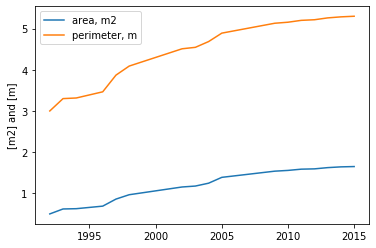

In [48]:
#now agg together for annual average area and perimeter
avg_module_area = wtd_module_area.agg('sum', 'columns')
avg_module_perimeter = wtd_module_perimeter.agg('sum', 'columns')

#print(avg_module_area)
#print(avg_module_perimeter)

plt.plot(avg_module_area, label='area, m2')
plt.plot(avg_module_perimeter, label = 'perimeter, m')
plt.legend()
plt.ylabel('[m2] and [m]')